Setting up Spark and Basic data cleaning

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# Create a Spark session
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .getOrCreate()

# Check if SparkSession is created successfully
print(spark)

24/07/07 12:32:14 WARN Utils: Your hostname, MacBook-Pro-Sunith.local resolves to a loopback address: 127.0.0.1; using 10.10.67.28 instead (on interface en0)
24/07/07 12:32:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/07 12:32:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pyspark.sql.functions import year, month, dayofmonth

/Users/sunith/opt/anaconda3/envs/dss/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
file_path = 'data/DataCoSupplyChainDataset.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)
# Some house cleaning where the the column names are standardized

for col in df.columns:
    new_col = col.replace(' ', '_').lower()
    df = df.withColumnRenamed(col, new_col)

df = df.withColumn("order_date", F.to_date(F.date_format(F.unix_timestamp("order_date_(dateorders)", "M/d/yyyy H:mm").cast("timestamp"), "yyyy-MM-dd")))
df = df.withColumn("shipping_date", F.to_date(F.date_format(F.unix_timestamp("shipping_date_(dateorders)", "M/d/yyyy H:mm").cast("timestamp"), "yyyy-MM-dd")))
df = df.withColumnRenamed('days_for_shipping_(real)', 'actual_time')
df = df.withColumnRenamed('days_for_shipment_(scheduled)', 'predicted_time')
df = df.withColumn("o_year", year(df["order_date"])) \
       .withColumn("o_month", month(df["order_date"])) \
       .withColumn("o_day", dayofmonth(df["order_date"]))

df = df.withColumn("s_year", year(df["shipping_date"])) \
       .withColumn("s_month", month(df["shipping_date"])) \
       .withColumn("s_day", dayofmonth(df["shipping_date"]))

In [4]:
df = df.drop('product_image', 'customer_password', 'customer_email', 
             'customer_fname', 'customer_lname', 'customer_street', 
             'latitude', 'longitude', 'product_description',
             "order_date_(dateorders)", "shipping_date_(dateorders)",
             'days_for_shipment_(scheduled)', 'days_for_shipping_(real)')    
df.createOrReplaceTempView("my_table")
df.show(5)

24/07/07 12:32:29 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+-----------+--------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+-----------+----------------+--------------+----------------+-------------+---------------+------------+----------+-------------+-----------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+---------------+-------------------+------------+-------------+--------------+--------------+----------+-------------+------+-------+-----+------+-------+-----+
|    type|actual_time|predicted_time|benefit_per_order|sales_per_customer| delivery_status|late_delivery_risk|category_id| category_name|customer_city|customer_country|customer_id|customer_segment|customer_state|customer_zipcode|department_id|department_na

In [81]:
spark.sql("""
          Select 
          product_card_id,
          shipping_mode,
          count(shipping_mode) as total_count,
          round(avg(late_delivery_risk),3) as risk,
          sum(case when delivery_status = "Late delivery" then 1 else 0 end) as avg_late,
          sum(case when delivery_status = "Shipping on time" then 1 else 0 end) as avg_on_time,
          sum(case when delivery_status = "Advance shipping" then 1 else 0 end) as avg_advance,
          sum(case when delivery_status = "Shipping canceled" then 1 else 0 end) as avg_cancel
          From my_table
          where product_card_id = 191
          group by product_card_id, shipping_mode
          order by product_card_id desc
          """).show(10)

+---------------+--------------+-----------+-----+--------+-----------+-----------+----------+
|product_card_id| shipping_mode|total_count| risk|avg_late|avg_on_time|avg_advance|avg_cancel|
+---------------+--------------+-----------+-----+--------+-----------+-----------+----------+
|            191|  Second Class|       2345|0.759|    1780|        463|          0|       102|
|            191|   First Class|       1879|0.957|    1799|          0|          0|        80|
|            191|Standard Class|       7302|0.379|    2768|       1369|       2853|       312|
|            191|      Same Day|        643|0.439|     282|        332|          0|        29|
+---------------+--------------+-----------+-----+--------+-----------+-----------+----------+



In [82]:
spark.sql("""
          Select 
          product_card_id,
          shipping_mode,
          count(shipping_mode) as total_count,
          round(avg(late_delivery_risk),3) as late_risk,
          round(sum(case when delivery_status = "Late delivery" then 1 else 0 end)/total_count,3) as avg_late,
          round(sum(case when delivery_status = "Shipping on time" then 1 else 0 end)/total_count,3) as avg_on_time,
          round(sum(case when delivery_status = "Advance shipping" then 1 else 0 end)/total_count,3) as avg_advance,
          round(sum(case when delivery_status = "Shipping canceled" then 1 else 0 end)/total_count,3) as avg_cancel
          From my_table
          where product_card_id = 191
          group by product_card_id, shipping_mode
          order by product_card_id desc
          """).show(10)

+---------------+--------------+-----------+---------+--------+-----------+-----------+----------+
|product_card_id| shipping_mode|total_count|late_risk|avg_late|avg_on_time|avg_advance|avg_cancel|
+---------------+--------------+-----------+---------+--------+-----------+-----------+----------+
|            191|  Second Class|       2345|    0.759|   0.759|      0.197|        0.0|     0.043|
|            191|   First Class|       1879|    0.957|   0.957|        0.0|        0.0|     0.043|
|            191|Standard Class|       7302|    0.379|   0.379|      0.187|      0.391|     0.043|
|            191|      Same Day|        643|    0.439|   0.439|      0.516|        0.0|     0.045|
+---------------+--------------+-----------+---------+--------+-----------+-----------+----------+



In [53]:
results1 = spark.sql("""
          Select 
          order_date,
          max(order_item_discount) as max_discount,
          min(order_item_discount) as min_discount,
          max(order_item_discount_rate) as max_drate,
          min(order_item_discount_rate) as min_drate,
          max(product_price) as price
          From my_table
          where product_card_id = 191
          and order_date between '2016-01-01' and '2016-06-30'
          group by order_date
          order by order_date desc
          """).toPandas()
results1

,order_date,max_discount,min_discount,max_drate,min_drate,price
0,2016-06-30,50.000000,0.0,0.25,0.00,99.989998
1,2016-06-29,59.990002,5.5,0.13,0.06,99.989998
2,2016-06-28,74.989998,2.0,0.16,0.01,99.989998
3,2016-06-27,84.989998,6.0,0.20,0.03,99.989998
4,2016-06-26,124.989998,0.0,0.25,0.00,99.989998
...,...,...,...,...,...,...
177,2016-01-05,51.990002,0.0,0.15,0.00,99.989998
178,2016-01-04,63.990002,13.0,0.17,0.03,99.989998
179,2016-01-03,99.989998,0.0,0.25,0.00,99.989998
180,2016-01-02,45.000000,3.0,0.18,0.01,99.989998


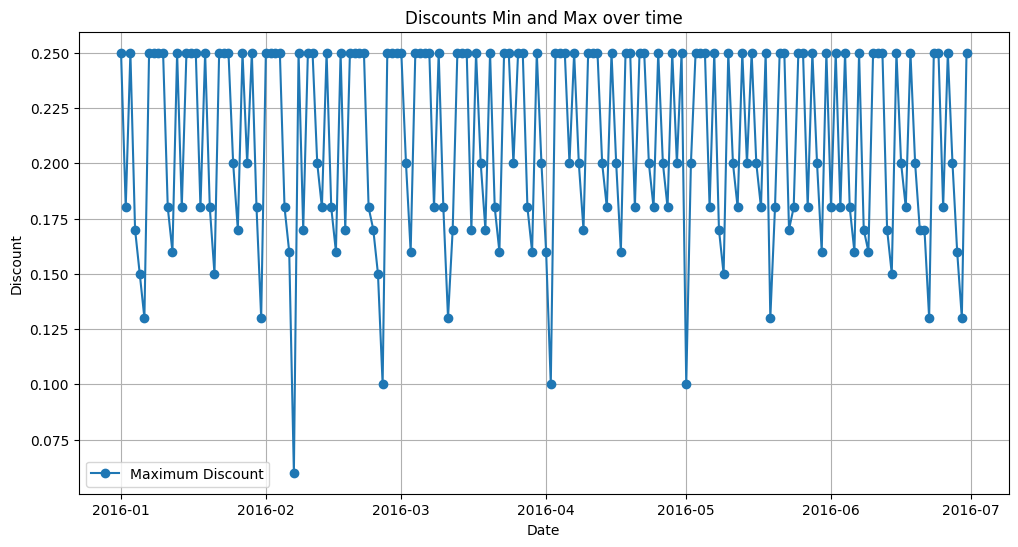

In [54]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(results1['order_date'], results1['max_drate'], label='Maximum Discount', marker='o')
# plt.plot(results1['order_date'], results1['min_drate'], label='Minimum Discount', marker='x')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Discount')
plt.title('Discounts Min and Max over time')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [44]:
spark.sql("""
          Select 
          order_id,
          order_date,
          order_profit_per_order,
          benefit_per_order,
          order_country
          From my_table
          where product_card_id = 191
          and order_date between '2016-01-01' and '2016-12-31'
          and order_item_discount > 100
          order by order_date desc
          """).show(10)

+--------+----------+----------------------+-----------------+--------------------+
|order_id|order_date|order_profit_per_order|benefit_per_order|       order_country|
+--------+----------+----------------------+-----------------+--------------------+
|   49646|2016-12-25|          -28.12000084|     -28.12000084|             Nigeria|
|   49057|2016-12-17|           179.9799957|      179.9799957|             Nigeria|
|   48713|2016-12-12|          -23.62000084|     -23.62000084|             Turqu�a|
|   48223|2016-12-04|           42.36999893|      42.36999893|             Hungr�a|
|   47841|2016-11-29|          -290.6000061|     -290.6000061|                Ir�n|
|   47509|2016-11-24|           140.6100006|      140.6100006|             Ucrania|
|   47053|2016-11-17|           70.48999786|      70.48999786|             Turqu�a|
|   46821|2016-11-14|          -637.4400024|     -637.4400024|                Irak|
|   46303|2016-11-06|                  37.5|             37.5|              

In [56]:
spark.sql("""
          Select 
          distinct(market)
          From my_table
          """).show(10)

+------------+
|      market|
+------------+
|      Europe|
|      Africa|
|Pacific Asia|
|       LATAM|
|        USCA|
+------------+



In [60]:
spark.sql("""
          Select 
          count(*) as count, market
          From my_table
          group by market
          order by count desc
          """).show(10)

+-----+------------+
|count|      market|
+-----+------------+
|51594|       LATAM|
|50252|      Europe|
|41260|Pacific Asia|
|25799|        USCA|
|11614|      Africa|
+-----+------------+



In [45]:
spark.sql("""
          Select 
          *
          From my_table
          where order_id = 49057
          """).show(10)

+-----+-----------+--------------+-----------------+------------------+---------------+------------------+-----------+----------------+-------------+----------------+-----------+----------------+--------------+----------------+-------------+---------------+------+----------+-------------+-----------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----------+----------------+----------------------+------------+-----------+------------+-------------+---------------+-------------------+--------------------+-------------+--------------+-------------+----------+-------------+------+-------+-----+------+-------+-----+
| type|actual_time|predicted_time|benefit_per_order|sales_per_customer|delivery_status|late_delivery_risk|category_id|   category_name|customer_city|customer_country|customer_id|customer_segment|customer_state|customer_zipcode|department_id|department_name|mark

In [ ]:
single_prod = spark.sql("""
        Select 
        shipping_mode,
        
        From my_table
        where product_card_id = 191
        group by shipping_mode
        """).toPandas()
single_prod

In [83]:
single_day = spark.sql("""
        Select 
        *
        From my_table
        where order_date = '2016-07-07'
        and product_card_id = 191
        """).toPandas()
single_day

,type,actual_time,predicted_time,benefit_per_order,sales_per_customer,delivery_status,late_delivery_risk,category_id,category_name,customer_city,...,product_status,shipping_mode,order_date,shipping_date,o_year,o_month,o_day,s_year,s_month,s_day
0,DEBIT,6,4,45.360001,94.489998,Late delivery,1,9,Cardio Equipment,Cordova,...,0,Standard Class,2016-07-07,2016-07-13,2016,7,7,2016,7,13
1,DEBIT,5,4,24.750000,197.979996,Late delivery,1,9,Cardio Equipment,Caguas,...,0,Standard Class,2016-07-07,2016-07-12,2016,7,7,2016,7,12
2,CASH,4,4,62.660000,296.970001,Shipping on time,0,9,Cardio Equipment,Detroit,...,0,Standard Class,2016-07-07,2016-07-11,2016,7,7,2016,7,11
3,DEBIT,2,1,172.410004,474.950012,Late delivery,1,9,Cardio Equipment,Caguas,...,0,First Class,2016-07-07,2016-07-09,2016,7,7,2016,7,9
4,DEBIT,6,4,69.739998,464.950012,Late delivery,1,9,Cardio Equipment,Cordova,...,0,Standard Class,2016-07-07,2016-07-13,2016,7,7,2016,7,13
5,DEBIT,4,2,82.309998,293.970001,Late delivery,1,9,Cardio Equipment,Endicott,...,0,Second Class,2016-07-07,2016-07-11,2016,7,7,2016,7,11
6,DEBIT,3,4,139.190002,479.950012,Advance shipping,0,9,Cardio Equipment,Caguas,...,0,Standard Class,2016-07-07,2016-07-10,2016,7,7,2016,7,10
7,PAYMENT,2,4,165.360001,472.450012,Advance shipping,0,9,Cardio Equipment,Caguas,...,0,Standard Class,2016-07-07,2016-07-09,2016,7,7,2016,7,9
8,TRANSFER,2,1,33.759998,92.989998,Late delivery,1,9,Cardio Equipment,Findlay,...,0,First Class,2016-07-07,2016-07-09,2016,7,7,2016,7,9
9,DEBIT,2,4,-198.729996,149.990005,Advance shipping,0,9,Cardio Equipment,Jamaica,...,0,Standard Class,2016-07-07,2016-07-09,2016,7,7,2016,7,9


In [33]:
monthly_demand = spark.sql("""
          Select 
          product_card_id,
          product_name,
          o_year,
          o_month,
          sum(order_item_quantity) as quantity
          From my_table
          group by product_card_id,
          product_name, o_year, o_month
          order by product_card_id, o_year, o_month
          """)
monthly_demand.show(10)
monthly_demand.toPandas().to_csv('output/monthly_demand.csv', encoding='utf-8', index=False)

+---------------+--------------------+------+-------+--------+
|product_card_id|        product_name|o_year|o_month|quantity|
+---------------+--------------------+------+-------+--------+
|             19|Nike Men's Finger...|  2017|      4|       2|
|             19|Nike Men's Finger...|  2017|      5|      13|
|             19|Nike Men's Finger...|  2017|      6|      13|
|             19|Nike Men's Finger...|  2017|      7|      15|
|             19|Nike Men's Finger...|  2017|      8|      17|
|             19|Nike Men's Finger...|  2017|      9|       4|
|             24|Elevation Trainin...|  2017|      4|      12|
|             24|Elevation Trainin...|  2017|      5|      71|
|             24|Elevation Trainin...|  2017|      6|      52|
|             24|Elevation Trainin...|  2017|      7|      45|
+---------------+--------------------+------+-------+--------+
only showing top 10 rows



This table tells me that a lot of the products that were first sold in the year 2015 were discountinued from october 2017. And the products that were launched on december 2017 do not overlap with any of the earlier products.

In [30]:
products = spark.sql("""
          Select 
          product_card_id,
          product_name,
          Max(product_price)       AS price,
          max(department_name) as dept_name,
          Max(category_id) as category_id,
          max(category_name) as category,
          min(order_date) as first_sale,
          max(order_date) as last_sale,
          Sum(order_item_quantity) AS quantity,
          Sum(sales)               AS total_sales
          From my_table
          GROUP  BY product_name,
                product_card_id
          order by product_card_id desc
          """)
products.show(10)
products.toPandas().to_csv('output/product_analysis.csv', encoding='utf-8', index=False)

+---------------+--------------------+-----------+------------------+-----------+-----------------+----------+----------+--------+------------------+
|product_card_id|        product_name|      price|         dept_name|category_id|         category|first_sale| last_sale|quantity|       total_sales|
+---------------+--------------------+-----------+------------------+-----------+-----------------+----------+----------+--------+------------------+
|           1363|      Summer dresses|215.8200073|           Apparel|         76| Women's Clothing|2017-12-11|2018-01-31|     650|140283.00474500025|
|           1362|Fighting video games|      39.75|        Discs Shop|         75|      Video Games|2017-12-08|2018-01-31|     838|           33310.5|
|           1361|               Toys |11.53999996|          Fan Shop|         74|             Toys|2017-12-04|2018-01-31|     529| 6104.659978840051|
|           1360|        Smart watch |     327.75|           Fitness|         73|   Sporting Goods|2

Calculating Lead time demands, lead time, safety stock and reporder points for each product

In [85]:
spark.sql("""
            Select product_name, product_card_id, order_date,
            sum(order_item_quantity) as quantity,
            round(avg(actual_time),0) as lead_time_odate,
            max(product_price) as p_price
            From my_table
            where o_year < 2017
            group by product_name, product_card_id, order_date
          """).show()

+--------------------+---------------+----------+--------+---------------+-----------+
|        product_name|product_card_id|order_date|quantity|lead_time_odate|    p_price|
+--------------------+---------------+----------+--------+---------------+-----------+
|Nike Men's Dri-FI...|            502|2015-02-28|      63|            4.0|       50.0|
|Nike Men's Dri-FI...|            502|2016-04-20|      57|            4.0|       50.0|
|Glove It Women's ...|            917|2016-09-07|       2|            5.0|21.98999977|
|Nike Dri-FIT Crew...|            135|2015-07-15|       6|            2.0|       22.0|
|Nike Men's CJ Eli...|            403|2015-11-26|      14|            4.0|129.9900055|
|Field & Stream Sp...|           1004|2016-01-12|      23|            4.0| 399.980011|
|Nike Men's Free 5...|            191|2015-04-28|      33|            3.0|99.98999786|
|Glove It Imperial...|            926|2015-12-01|       3|            5.0|15.98999977|
|Nike Men's Dri-FI...|            502|2015-

In [5]:
output = spark.sql("""
                    With T1 AS (
                    Select product_name, product_card_id, order_date,
                    sum(order_item_quantity) as quantity,
                    round(avg(actual_time),0) as lead_time_odate,
                    max(product_price) as p_price
                    From my_table
                    where o_year < 2017
                    group by product_name, product_card_id, order_date
                    )

                    Select product_name, product_card_id, 
                    round(avg(quantity),3) as avg_demand,
                    round(STDDEV(quantity),3) as std_dev_demand,
                    round(avg(lead_time_odate),0) as lead_time,
                    round(STDDEV(lead_time_odate),0) as stddev_lead_time,
                    round(lead_time * avg_demand,3) as lead_time_demand,
                    round(1.64*std_dev_demand*sqrt(lead_time),0) as safety_stock,
                    round(lead_time_demand+safety_stock,0) as reorder_point,
                    max(p_price) as price,
                    0.1*price as holding,
                    0.3*price as ordering,
                    Round(sqrt((2*avg_demand*365*ordering)/holding),0) as EOQ
                    from T1
                    group by product_name, product_card_id
                    order by avg_demand desc
                    """)
output.show(5)
output.toPandas().to_csv('product_SC_analysis.csv', index=False)

+--------------------+---------------+----------+--------------+---------+----------------+----------------+------------+-------------+-----------+------------------+------------------+-----+
|        product_name|product_card_id|avg_demand|std_dev_demand|lead_time|stddev_lead_time|lead_time_demand|safety_stock|reorder_point|      price|           holding|          ordering|  EOQ|
+--------------------+---------------+----------+--------------+---------+----------------+----------------+------------+-------------+-----------+------------------+------------------+-----+
|Perfect Fitness P...|            365|    73.722|        16.769|      4.0|             1.0|         294.888|        55.0|        350.0|59.99000168|       5.999000168|      17.997000504|402.0|
|Nike Men's Dri-FI...|            502|    62.516|        16.131|      4.0|             1.0|         250.064|        53.0|        303.0|       50.0|               5.0|              15.0|370.0|
|O'Brien Men's Neo...|           1014|  

* avg_demand = average quantity ordered per day for every product
* std_dev_demand = std. dev. of the daily quantity demanded for each product
* lead_time = average actual shipping time for every product
* lead_time_demand = lead_time * avg_demand
* safety_stock = 1.64 * std_dev_demand * sqrt(lead_time)
* reorder_point = lead_time_demand + safety_stock
* holding = 0.1*price
* ordering = 0.3*price
* EOQ = Round(sqrt((2 * (avg_demand * 365) * ordering)/holding),0)

If we are looking at data only before 2017 then there are just 54 products being sold.

## Obtaining Forcasts

In [6]:
xx = spark.sql("""
            Select product_name, product_card_id,
            sum(order_item_quantity) as quantity
            From my_table
            where o_year < 2017
            group by product_name, product_card_id
            order by quantity desc
        """).toPandas()
prod_list = xx['product_card_id']

In [7]:
products_dtl = spark.sql("""Select product_name, product_card_id, 
                         department_name
          from my_table
          group by product_name, product_card_id, department_name
          order by product_card_id""")
products_dtl.show(5)
products_dtl.toPandas().to_csv('product_dict.csv', index=False)

+--------------------+---------------+---------------+
|        product_name|product_card_id|department_name|
+--------------------+---------------+---------------+
|Nike Men's Finger...|             19|        Fitness|
|Elevation Trainin...|             24|        Fitness|
|adidas Brazuca 20...|             35|        Fitness|
|adidas Kids' F5 M...|             37|        Fitness|
|adidas Men's F10 ...|             44|        Fitness|
+--------------------+---------------+---------------+
only showing top 5 rows



In [8]:
def forecast(id, initial_year, final_year):
    query1 = f"""
            CREATE OR REPLACE TEMPORARY VIEW actual AS
            Select order_date as ds,
            sum(order_item_quantity) as y
            From my_table
            Where product_card_id = {id}
            AND o_year Between {initial_year} and {final_year}
            group by ds
            order by ds
        """
    
    spark.sql(query1)
    
    query2 = f"""
        SELECT order_date as ds,
               SUM(order_item_quantity) as y
        FROM my_table
        WHERE product_card_id = {id}
          AND o_year < {initial_year}
        GROUP BY order_date
        ORDER BY order_date
    """
    prophet_df = spark.sql(query2).toPandas()

    prophet = Prophet(seasonality_mode='additive', 
                        seasonality_prior_scale=1, 
                        holidays_prior_scale=5, 
                        changepoint_prior_scale=0.005)
    prophet.fit(prophet_df)
    # Create a DataFrame with future dates for forecasting
    future = prophet.make_future_dataframe(periods=30, freq='D')
    # Generate forecasts
    forecast = prophet.predict(future) 
    

    spark_df = spark.createDataFrame(forecast)
    spark_df.createOrReplaceTempView("predicted")
    query3 = f"""
            CREATE OR REPLACE TEMPORARY VIEW predicted_filter AS
            Select ds, yhat
            from predicted
            where ds >= '{initial_year}-01-01'
            """
    spark.sql(query3)
    query4 = f"""
            select {id} as product_card_id, p.*, a.y
            from predicted_filter as p
            left join actual as a on a.ds = p.ds
            """
    
    results = spark.sql(query4).toPandas()

    return results


In [9]:
results = forecast(191,2017,2018)

15:13:44 - cmdstanpy - INFO - Chain [1] start processing                        
15:13:44 - cmdstanpy - INFO - Chain [1] done processing


In [102]:
final_df = pd.DataFrame()

for id in prod_list:
    results = forecast(id,2017,2018)    
    final_df = pd.concat([final_df, results], ignore_index=True)

00:59:08 - cmdstanpy - INFO - Chain [1] start processing                        
00:59:09 - cmdstanpy - INFO - Chain [1] done processing
00:59:11 - cmdstanpy - INFO - Chain [1] start processing                        
00:59:11 - cmdstanpy - INFO - Chain [1] done processing
00:59:13 - cmdstanpy - INFO - Chain [1] start processing
00:59:13 - cmdstanpy - INFO - Chain [1] done processing
00:59:15 - cmdstanpy - INFO - Chain [1] start processing                        
00:59:15 - cmdstanpy - INFO - Chain [1] done processing
00:59:18 - cmdstanpy - INFO - Chain [1] start processing                        
00:59:18 - cmdstanpy - INFO - Chain [1] done processing
00:59:21 - cmdstanpy - INFO - Chain [1] start processing                        
00:59:21 - cmdstanpy - INFO - Chain [1] done processing
00:59:23 - cmdstanpy - INFO - Chain [1] start processing                        
00:59:23 - cmdstanpy - INFO - Chain [1] done processing
00:59:25 - cmdstanpy - INFO - Chain [1] start processing
00:59:25

In [97]:
final_df.to_csv('forecasts.csv', index=False)

Visualize for a product of your choice

In [106]:
results = final_df[final_df['product_card_id'] == 191]
results.head(5)

,product_card_id,ds,yhat,y
90,191,2017-01-01,34.357626,44.0
91,191,2017-01-02,34.154553,45.0
92,191,2017-01-03,33.862044,24.0
93,191,2017-01-04,34.341459,41.0
94,191,2017-01-05,33.091643,40.0


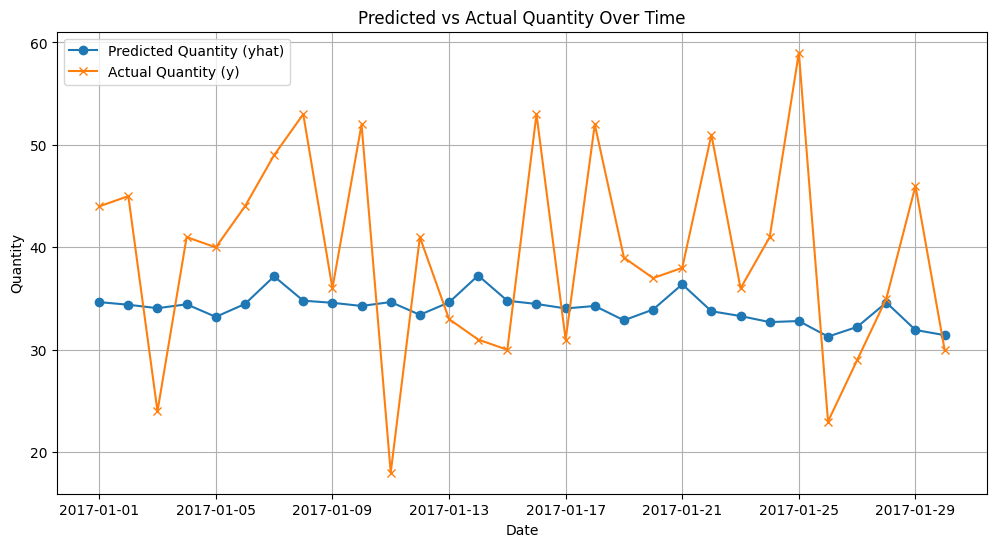

In [10]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(results['ds'], results['yhat'], label='Predicted Quantity (yhat)', marker='o')
plt.plot(results['ds'], results['y'], label='Actual Quantity (y)', marker='x')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Predicted vs Actual Quantity Over Time')
plt.legend()

# Show plot
plt.grid(True)
plt.show()